In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install wurlitzer

In [3]:
!pip uninstall keras -y  # Force uninstall Keras
!pip install tensorflow==2.15.0  # Reinstall TensorFlow to ensure consistency

Found existing installation: keras 2.15.0
Uninstalling keras-2.15.0:
  Successfully uninstalled keras-2.15.0
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)


In [4]:
import os
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

2024-03-13 09:09:18.766786: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 09:09:18.766844: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 09:09:18.768429: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
device_name = tf.test.gpu_device_name()
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

if tf.config.list_physical_devices('GPU'):
    gpu_info = tf.config.list_physical_devices('GPU')[0]
    print(f"GPU Name: {gpu_info.name}")

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow version: 2.15.0
Num GPUs Available:  1
GPU Name: /physical_device:GPU:0
Found GPU at: /device:GPU:0


Data Generator

In [6]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels

class FunctionRegressionDataGenerator:
    def __init__(self, batch_size=64, max_num_context=10, testing=False):
        self.batch_size = batch_size
        self.max_num_context = max_num_context
        self.testing = testing

    def generate_curves(self):
        # Define two kernels with different parameters
        kernel1 = psd_kernels.ExponentiatedQuadratic(amplitude=1.0, length_scale=0.4)
        kernel2 = psd_kernels.ExponentiatedQuadratic(amplitude=0.5, length_scale=0.2)

        num_context = tf.random.uniform(shape=[], minval=5, maxval=self.max_num_context, dtype=tf.int32)

        # Common settings for both testing and training
        num_target = 400 if self.testing else tf.random.uniform(shape=[], minval=2, maxval=self.max_num_context, dtype=tf.int32)
        num_total_points = num_target if self.testing else num_context + num_target
        x_values = tf.linspace(-2., 2., num_target) if self.testing else tf.random.uniform((self.batch_size, num_total_points, 1), minval=-2., maxval=2.)

        # Switch point determines where to switch between the two kernels
        switch_point = tf.random.uniform(shape=[], minval=-2., maxval=2., dtype=tf.float32)

        # Ensure x_values has three dimensions
        if len(x_values.shape) == 1:
            x_values = tf.expand_dims(x_values, axis=-1)  # Add the missing dimension
            x_values = tf.expand_dims(x_values, axis=0)  # Add batch dimension if missing

        # Determine indices for switching
        switch_indices = tf.cast(x_values[:, :, 0] < switch_point, dtype=tf.int32)

        # Create two GPs for each segment
        gp1 = tfd.GaussianProcess(kernel1, index_points=x_values, jitter=1.0e-4)
        gp2 = tfd.GaussianProcess(kernel2, index_points=x_values, jitter=1.0e-4)

        # Sample from both GPs
        y_values1 = gp1.sample()
        y_values2 = gp2.sample()

        # Ensure y_values1 and y_values2 have an additional last dimension to match the condition tensor shape
        y_values1 = tf.expand_dims(y_values1, axis=-1)
        y_values2 = tf.expand_dims(y_values2, axis=-1)

        # Select the y-values based on the switch indices
        y_values = tf.where(switch_indices[..., tf.newaxis] == 1, y_values1, y_values2)
        #y_values = tf.expand_dims(y_values, axis=-1)

        # Setup context and target points as in the fixed kernel version
        if self.testing:
            target_x = x_values
            target_y = y_values
            idx = tf.random.shuffle(tf.range(num_target))
            context_x = tf.gather(x_values, idx[:num_context], axis=1)
            context_y = tf.gather(y_values, idx[:num_context], axis=1)
        else:
            target_x = x_values[:, :num_target + num_context, :]
            target_y = y_values[:, :num_target + num_context, :]
            context_x = x_values[:, :num_context, :]
            context_y = y_values[:, :num_context, :]

        yield (context_x, context_y, target_x), target_y


Encoder

In [7]:
# encoder.py
class Encoder(layers.Layer):
    def __init__(self, output_sizes):
        super(Encoder, self).__init__()
        self.output_sizes = output_sizes
        self.dense_layers = [layers.Dense(size, activation='relu') for size in output_sizes[:-1]]
        self.dense_layers.append(layers.Dense(output_sizes[-1]))

    def call(self, context_x, context_y):
        # `context_x` shape (batch_size, observation_points, x_dim)
        # `context_y` shape (batch_size, observation_points, y_dim)
        encoder_input = tf.concat([context_x, context_y], axis=-1)
        batch_size, num_context_points, filter_size = tf.shape(encoder_input)[0], tf.shape(encoder_input)[1], tf.shape(encoder_input)[2]

        hidden = tf.reshape(encoder_input, (batch_size * num_context_points, -1))
        
        for layer in self.dense_layers:
            hidden = layer(hidden)
        
        hidden = tf.reshape(hidden, (batch_size, num_context_points, -1))
        representation = tf.reduce_mean(hidden, axis=1)
        
        return representation

Decoder

In [8]:
# decoder.py
class Decoder(layers.Layer):
    def __init__(self, output_sizes):
        super(Decoder, self).__init__()
        self.output_sizes = output_sizes
        # Initialize dense layers for MLP, using ReLU for all but last layer
        self.dense_layers = [layers.Dense(size, activation='relu') for size in output_sizes[:-1]]
        # Last layer without activation function
        self.dense_layers.append(layers.Dense(output_sizes[-1]))

    def call(self, representation, target_x):
        # Infer num_total_points from target_x
        num_total_points = tf.shape(target_x)[1]

        # Expand dims of representation to match target_x, then concatenate
        representation = tf.tile(tf.expand_dims(representation, axis=1), [1, num_total_points, 1])
        decoder_input = tf.concat([representation, target_x], axis=-1)

        batch_size, _, filter_size = decoder_input.shape
        hidden = tf.reshape(decoder_input, (batch_size * num_total_points, -1))

        # Pass through MLP
        for layer in self.dense_layers:
            hidden = layer(hidden)

        # Reshape to get back to the original batch and num_total_points dimensions
        hidden = tf.reshape(hidden, (batch_size, num_total_points, -1))

        # Split the output into mean and log variance
        mu, log_sigma = tf.split(hidden, 2, axis=-1)

        # Ensure variance is positive and bounded
        sigma = 0.1 + 0.9 * tf.nn.softplus(log_sigma)

        # Return a tuple of distribution parameters (mu and sigma)
        return mu, sigma


Model

In [9]:
# cnp_model.py

class CNPModel(Model):
    def __init__(self, encoder_output_sizes, decoder_output_sizes):
        super(CNPModel, self).__init__()
        self.encoder = Encoder(encoder_output_sizes)
        self.decoder = Decoder(decoder_output_sizes)

    def call(self, inputs):
        context_x, context_y, target_x = inputs
        representations = self.encoder(context_x, context_y)
        mu, sigma = self.decoder(representations, target_x)

        return tf.concat([mu, sigma], axis=-1)

Plotting Function

In [10]:
# plot.py

def plot_functions(target_x, target_y, context_x, context_y, pred_y, var):

    plt.figure(figsize=(6, 4))  # Adjust the figure size as needed

    # Plot the true function, predicted mean, and context points
    plt.plot(target_x[0], target_y[0], 'k-', linewidth=2, label='True Function')
    plt.plot(target_x[0], pred_y[0], 'b', linewidth=2, label='Predicted Mean')
    plt.plot(context_x[0], context_y[0], 'ko', markersize=10, label='Context Points')

    # Fill the area between the variance bounds with a new color
    plt.fill_between(
        target_x[0, :, 0],
        pred_y[0, :, 0] - var[0, :, 0],
        pred_y[0, :, 0] + var[0, :, 0],
        alpha=0.2,
        color='purple',  # Changed color to light green
        label='Confidence Interval'
    )

    # Labels and title for better context
    plt.xlabel('x', fontsize=14)
    plt.ylabel('y', fontsize=14)
    plt.title('Function Prediction with CNP', fontsize=16)

    # Adjust the y and x axis ticks for readability
    # Adjust the y and x axis ticks for the plot
    plt.yticks([-2, -1, 0, 1, 2], fontsize=12)
    plt.xticks([-2, -1, 0, 1, 2], fontsize=12)
    #plt.yticks(fontsize=12)
    #plt.xticks(fontsize=12)

    # Set the y-axis limits to match your data's scale better
    plt.ylim([-2, 2])

    # Enable the grid for better readability
    plt.grid(True, linestyle='--', alpha=0.6)

    # Modify the legend to improve readability
    # Add a legend outside of the plot to the right
    plt.legend(loc='upper left', fontsize=6, bbox_to_anchor=(1, 1))
    #plt.legend(loc='upper right', frameon=True, fontsize=12)


    # Show the plot with a tight layout to ensure no clipping
    plt.tight_layout()
    plt.savefig('./cnpplot.png')
    plt.show()


Training set up

In [11]:
batch_size = 64  # Example batch size
max_num_context = 10  # Maximum number of context points
TRAINING_ITERATIONS = int(2e5)
PLOT_AFTER = int(2e4)

# Instantiate the data generators
train_data_generator = FunctionRegressionDataGenerator(batch_size=batch_size, max_num_context=max_num_context, testing=False)
test_data_generator = FunctionRegressionDataGenerator(batch_size=1, testing=True)

# Create TensorFlow datasets with specified output shapes
train_dataset = tf.data.Dataset.from_generator(
    train_data_generator.generate_curves,
    output_signature=(
        (
            tf.TensorSpec(shape=(None, None, 1), dtype=tf.float32),  # context_x
            tf.TensorSpec(shape=(None, None, 1), dtype=tf.float32),  # context_y
            tf.TensorSpec(shape=(None, None, 1), dtype=tf.float32)   # target_x
        ),
        tf.TensorSpec(shape=(None, None, 1), dtype=tf.float32)       # target_y
    )
)  # Ensure to batch your training dataset

test_dataset = tf.data.Dataset.from_generator(
    test_data_generator.generate_curves,
    output_signature=(
        (
            tf.TensorSpec(shape=(None, None, 1), dtype=tf.float32),  # context_x
            tf.TensorSpec(shape=(None, None, 1), dtype=tf.float32),  # context_y
            tf.TensorSpec(shape=(None, None, 1), dtype=tf.float32)   # target_x
        ),
        tf.TensorSpec(shape=(None, None, 1), dtype=tf.float32)       # target_y
    )
)  # No need to batch if evaluating one at a time, but you might want to add `.batch(1)` for consistency


In [12]:
encoder_layers = [128, 128, 128]
decoder_layers = [128, 128, 128, 128, 2]

# Define the model
model = CNPModel(encoder_layers, decoder_layers)
optimizer = tf.optimizers.Adam(learning_rate=1e-4)

In [13]:
def loss_fn(target_y, pred_y):
    # Get the distribution
    mu, sigma = tf.split(pred_y, num_or_size_splits=2, axis=-1)
    dist = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
    return -tf.math.reduce_mean(dist.log_prob(target_y))

In [14]:
@tf.function(reduce_retracing=True)
def train_step(model, context_x, context_y, target_x, target_y):
    with tf.GradientTape() as tape:
        # Pass context and target_x to the model to get the predicted distribution
        predicted_distribution = model((context_x, context_y, target_x))
        # Calculate the loss
        loss = loss_fn(target_y, predicted_distribution)

    # Compute gradients and apply them to update the model's parameters
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

Initializing from scratch.


Training Progress:   0%|          | 0/200000 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1710321072.986397     446 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Iteration: 0, Loss: 1.3440576791763306


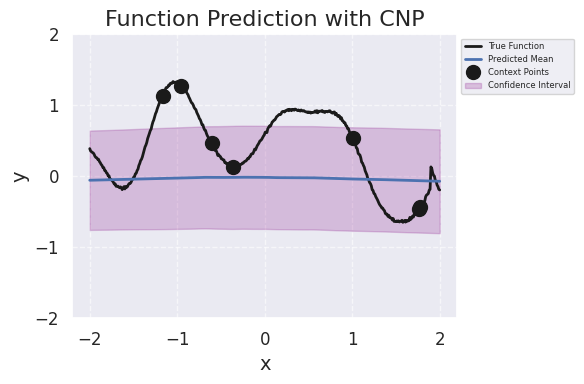

Training Progress:   0%|          | 188/200000 [00:28<5:24:08, 10.27it/s]

In [ ]:
from tqdm import tqdm

# Assuming `model` and `optimizer` are defined
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
checkpoint_directory = "/kaggle/working/checkpoints"
manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_directory, max_to_keep=5)

# Restore from the latest checkpoint
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")
    
best_loss = float('inf')

for it in tqdm(range(TRAINING_ITERATIONS), desc='Training Progress'):
    for ((context_x, context_y, target_x), target_y) in train_dataset:
        loss = train_step(model, context_x, context_y, target_x, target_y)

    if it % PLOT_AFTER == 0:
        test_data_iter = iter(test_dataset.take(1))
        try:
            ((test_context_x, test_context_y, test_target_x), test_target_y) = next(test_data_iter)

            predicted_dist = model([test_context_x, test_context_y, test_target_x])
            mu, sigma = tf.split(predicted_dist, num_or_size_splits=2, axis=-1)
            
            if loss < best_loss:
                best_loss = loss
                # Construct the checkpoint name with iteration number and loss
                custom_checkpoint_name = f"ckpt_iter_{it}"
                custom_checkpoint_path = f"{checkpoint_directory}/{custom_checkpoint_name}"
                save_path = checkpoint.save(custom_checkpoint_path)

            print(f'Iteration: {it}, Loss: {loss.numpy()}')
            # Ensure your `plot_functions` is correctly defined to visualize results
            plot_functions(test_target_x.numpy(), test_target_y.numpy(), test_context_x.numpy(), test_context_y.numpy(), mu.numpy(), sigma.numpy())
        except StopIteration:
            print(f'Iteration: {it}, No more data to plot.')

Testing

In [ ]:
#import os

# Specify the directory path you want to create
#directory_path = '/kaggle/working/checkpoints'

# Create the directory, including any necessary parent directories
#try:
#    os.makedirs(directory_path)
#    print(f"Directory {directory_path} was created successfully.")
#except FileExistsError:
#    print(f"Directory {directory_path} already exists.")

In [ ]:
import os

checkpoint_directory = "/kaggle/working/checkpoints"

# Check if the directory exists
if os.path.exists(checkpoint_directory):
    # List all files and directories in the checkpoint directory
    files = os.listdir(checkpoint_directory)
    print("Contents of the checkpoint directory:")
    for file in files:
        print(file)
else:
    print(f"The directory {checkpoint_directory} does not exist.")

In [ ]:
import os

checkpoint_directory = "/kaggle/working/"

# Check if the directory exists
if os.path.exists(checkpoint_directory):
    # List all files and directories in the checkpoint directory
    files = os.listdir(checkpoint_directory)
    print("Contents of the checkpoint directory:")
    for file in files:
        print(file)
else:
    print(f"The directory {checkpoint_directory} does not exist.")

In [ ]:
#import os

#file_path = '/kaggle/working/cnpplot'  # Change this to your file's path

# Check if the file exists to avoid errors
#if os.path.exists(file_path):
#    os.remove(file_path)
#    print(f"The file {file_path} has been deleted.")
#else:
 #   print(f"The file {file_path} does not exist.")

In [ ]:
test_data_gen = FunctionRegressionDataGenerator(batch_size=1, max_num_context=10, testing=True)
test_data = tf.data.Dataset.from_generator(
    test_data_gen.generate_curves,
    output_signature=(
        (
            tf.TensorSpec(shape=(None, None, 1), dtype=tf.float32),  # context_x
            tf.TensorSpec(shape=(None, None, 1), dtype=tf.float32),  # context_y
            tf.TensorSpec(shape=(None, None, 1), dtype=tf.float32)   # target_x
        ),
        tf.TensorSpec(shape=(None, None, 1), dtype=tf.float32)       # target_y
    )
)  # No need to batch if evaluating one at a time, but you might want to add `.batch(1)` for consistency


In [ ]:
test_data_iter = iter(test_data.take(1))
((test_context_x, test_context_y, test_target_x), test_target_y) = next(test_data_iter)

predicted_dist = model([test_context_x, test_context_y, test_target_x])
mu, sigma = tf.split(predicted_dist, num_or_size_splits=2, axis=-1)
            
# Ensure your `plot_functions` is correctly defined to visualize results
plot_functions(test_target_x.numpy(), test_target_y.numpy(), test_context_x.numpy(), test_context_y.numpy(), mu.numpy(), sigma.numpy())

GPs

In [ ]:
import tensorflow_probability as tfp
import tensorflow as tf

tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels

# Define the kernel
amplitude = tf.constant(1.0, dtype=tf.float32)
length_scale = tf.constant(0.4, dtype=tf.float32)
kernel = psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

# Define the Gaussian Process Regression Model
gp = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=test_target_x,
    observation_index_points=test_context_x,
    observations=test_context_y[..., 0],
    observation_noise_variance=1e-4
)

# GP predictions for plotting
mean_fn = gp.mean()
stddev_fn = gp.stddev()

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

def plot_gp_regression(test_context_x, test_context_y, test_target_x, test_target_y, mean_fn, stddev_fn):
    
    plt.figure(figsize=(6, 4))  # Adjust the figure size as needed

    """Plot Gaussian Process regression."""
    # Convert tensors to numpy arrays for plotting
    test_context_x = test_context_x.numpy()
    test_context_y = test_context_y.numpy()
    test_target_x = test_target_x.numpy()
    test_target_y = test_target_y.numpy()
    mean_fn = mean_fn.numpy()
    stddev_fn = stddev_fn.numpy()
    
    
    plt.plot(test_target_x.squeeze(), test_target_y.squeeze(), 'k-', linewidth=2, label='True Function')
    plt.plot(test_target_x.squeeze(), mean_fn.squeeze(), 'b', linewidth=2, label='Predicted Mean')
    plt.plot(test_context_x.squeeze(), test_context_y.squeeze(), 'ko', markersize=10, label='Context Points')
    plt.fill_between(test_target_x.squeeze(), 
                     (mean_fn - stddev_fn).squeeze(), 
                     (mean_fn + stddev_fn).squeeze(), 
                     color='purple', alpha=0.2, label='Confidence Interval')

    
    
    # Labels and title for better context
    plt.xlabel('x', fontsize=14)
    plt.ylabel('y', fontsize=14)
    plt.title('Function Prediction with GP', fontsize=16)

    # Adjust the y and x axis ticks for readability
    # Adjust the y and x axis ticks for the plot
    plt.yticks([-2, -1, 0, 1, 2], fontsize=12)
    plt.xticks([-2, -1, 0, 1, 2], fontsize=12)

    # Set the y-axis limits to match your data's scale better
    plt.ylim([-2, 2])

    # Enable the grid for better readability
    plt.grid(True, linestyle='--', alpha=0.6)

    # Modify the legend to improve readability
    # Add a legend outside of the plot to the right
    plt.legend(loc='upper left', fontsize=6, bbox_to_anchor=(1, 1))
    #plt.legend(loc='upper right', frameon=True, fontsize=12)


    # Show the plot with a tight layout to ensure no clipping
    plt.tight_layout()
    plt.savefig('./gpplot.png')
    plt.show()

In [ ]:
# Usage example:
plot_gp_regression(test_context_x, test_context_y, test_target_x, test_target_y, mean_fn, stddev_fn)